# todo

In [1]:
import netCDF4
import string
import platform
import os

* **Done** Time = 480  can we make this lowercase? 'time'; if we do that in the definition up top it should carry it through all the variable dimensions, right?
* **not necessary, in fact my programm does not even allow it, it takes care of it it self** to the 'time' variable add an identifier for time zone :units="seconds since 1995-5-10 00:00:00 0:00" - so adding the final 0:00 after a space indicates 0 offset from UTC
* **Done** int time variable needs :epoch_time attribute - Ken says it's a number you need to calculate but trivial with Python utility and this will help users to calculate time easily without having to parse the other string/array
* **Done** multiple variables in the :ancillary_variables attribute should be separated by spaces and not commas so the commas should be removed
* **Done** variable 'diffuse_shortwave_irloss_flag' - "shortwave" is misspelled
* **Done** for variables 'wind_speed' and 'wind_direction' can we change the comments to "measured at top of tower"
* **Done ... i think** there are a couple of added variables in there that we're not sure what they're for  :type = "byte" and :Coordinates = "Time" - these pooped up in some of the variables and are not needed and potentially contradictory with the variable definition - can we take all of these out?
* **Done** add a //global_attribute :history = "this file was created on <time stamp> on the machine <name machine>" - this will help with troubleshooting down the road if needed

* **Yes** are you using netCDF 4 libraries?
* **Done** do you have the 'classic mode' switch on which makes it back-compatible? Ken recommends this

**disagreed, see section 2.4 ... http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#dimensions** The "coordinates" attribute (attribute's name case matters) is intended to point to other coordinate variables that should be used to describe the data in space. There is an example of the use in section 5.3. Since you are just presenting a time series I suggest taking that attribute out.

**Gone** I can't find any description of an attribute called "type" in CF. I suggest taking it out.

**I prefere without it since my library is taking care of that it self and does not allow me to change it** CF section 4.4 has an example of using the "0:00" timezone offset if you want to understand that more. The Standard does say "Note: if the time zone is omitted the default is UTC, and if both time and time zone are omitted the default is 00:00:00 UTC." So you can apparently leave it off if you prefer.

Here is the description of "calendar" that makes me think what you have is correct: "For time coordinates that do cross the discontinuity the proleptic_gregorian calendar should be used instead."

# imports 

In [4]:
import hashlib
import os

# Using the cdl file

seperate processing from file selection

In [1]:
from SurfRadPy import NCEI as ncei

In [4]:
ncei.qcrad2netcdf('../data/bon_19950510.qdat', '../data/', '../data/SURFRAD_QCrad_metadata.cdl', overwrite=True)

In [81]:
reload(ncei)

<module 'SurfRadPy.NCEI' from '/Users/htelg/prog/SURFRAD/SurfRadPy/NCEI.py'>

In [85]:
df = ncei.tar_netcdf_files("/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/1995/", '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/', overwrite= True, test=False, verbose=True)

In [86]:
import os as _os
from SurfRadPy.surfrad import locations as _locations

In [137]:
import pandas as _pd
import numpy as _np

In [135]:
from SurfRadPy import surfrad

In [187]:
from pathlib import Path

In [429]:
reload(ncei)

<module 'SurfRadPy.NCEI' from '/Users/htelg/prog/SURFRAD/SurfRadPy/NCEI.py'>

In [430]:
df = ncei.qcrad2ncei(folder_in = '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/',
           folder_out= '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/',
           folder_out_tar= '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_tar/',
           station_abb = 'bon',
           year = 1995,
           month = 1,
           overwrite = True,
           do_qcrad2nc = True,
           do_tar = True,
           do_manifest = True,
           test = False,
           verbose = True)

pcrad2netcdf: /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/bon/1995/bon_19950101.qdat -> /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bon/Bondville_IL_1995_Jan_01.nc...done
pcrad2netcdf: /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/bon/1995/bon_19950102.qdat -> /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bon/Bondville_IL_1995_Jan_02.nc...done
pcrad2netcdf: /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/bon/1995/bon_19950103.qdat -> /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bon/Bondville_IL_1995_Jan_03.nc...done
pcrad2netcdf: /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/bon/1995/bon_19950104.qdat -> /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bon/Bondville_IL_1995_Jan_04.nc...done
pcrad2netcdf: /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/bon/1995/bon_19950105.qdat -> /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bon/Bondville_IL_1995_Jan_05.nc...done
pcrad2netcdf: /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/bon/1995/bon_19950106.qdat -> /Volumes/HTelg_4TB_Backup/GRAD/SU

In [ ]:
import argparse

txt = """Process qcrad data to conform with NCEI requirements. This includes conversion to netCDF, archiving, and the generation of a manifest file."""
parser = argparse.ArgumentParser(prog='qcrad2ncei', description=txt)

default_input_folder = '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/'
default_output_folder= '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/'
default_tar_folder= '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_tar/'

parser.add_argument('-i','--folder_in', 
#                     nargs = 1,
                    default=default_input_folder,
                    help='Change the input folder. This is the basefolder containing all qcrad data. Default: {}.'.format(default_input_folder))
parser.add_argument('-o','--folder_out', 
#                     nargs = 1,
                    default=default_output_folder,
                    help='Change the output folder. This is the basefolder where all the netCDF files will be stored in. Default: {}.'.format(default_output_folder))
parser.add_argument('-a','--folder_tar', 
#                     nargs = 1,
                    default=default_tar_folder,
                    help='Change the archive folder. This is the basefolder where all the data archives (tar) will be stored. Default: {}.'.format(default_tar_folder))
parser.add_argument('-w','--overwrite', 
                    action="store_true",
                    help='Overwrite existing output (netCDF) files.')
parser.add_argument('-s','--station', 
#                     nargs = 1,
                    default = None,
                    help='Stations to process (default is all stations). Options: {}'.format(', '.join([i['abbriviations'][-1] for i in _locations])))
parser.add_argument('-y','--year',
#                    nargs = 1,
                   default = None,
                   type=int,
                   help='Year to process (default is all years). Format: yyyy')
parser.add_argument('-m','--month',
#                    nargs = 1,
                   default = None,
                   type=int,
                   help='Month to process (default is all month). Format: mm')
parser.add_argument('-t', '--test', 
                   action="store_true",
                   help='Suppresses the processing, but print files that would be processed.')
parser.add_argument('-v', '--verbose',
                   action="store_true",
                   help='Increase output verbosity.')
parser.add_argument('--suppress_netcdf',
                   action='store_false',
                   help='Suppress the generation of the netCDF generation. E.g. if only the archives are supposed to be generated.')
parser.add_argument('--suppress_archive',
                   action='store_false',
                   help='Suppress the generation of the archives (tar files).')
parser.add_argument('--suppress_manifest',
                   action='store_false',
                   help='Suppress the generation of manifest files.')
parser.print_help()

In [519]:
args = parser.parse_args(['-t','-y','1995','-m','01'])

In [520]:
args.suppress_netcdf

True

In [431]:
args = parser.parse_args()
df = ncei.qcrad2ncei(folder_in = args.folder_in,
           folder_out= args.folder_out,
           folder_out_tar= args.folder_tar,
           station_abb = args.station,
           year = args.year,
           month = args.month,
           overwrite = args.overwrite,
           do_qcrad2nc = args.suppress_netcdf,
           do_tar = args.suppress_archive,
           do_manifest = args.suppress_manifest,
           test = args.test,
           verbose = args.verbose)

In [499]:
not args.suppress_archive

False

In [466]:
[i['abbriviations'][-1] for i in _locations]

['bon', 'sxf', 'tbl', 'dra', 'fpk', 'gwn', 'psu', 'sgp']

In [277]:
folder_in = '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v3/'
folder_out= '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/'
folder_out_tar= '/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_tar/'
fl_ext = '.tar.gz'

In [363]:
paths_in = list(Path(folder_in).rglob("*.qdat"))
# paths_out = [Path(i.as_posix().replace(folder_in, folder_out)) for i in paths_in]
paths_out_exist = [i.is_file() for i in paths_out]
index = [pd.to_datetime(i.name.split('_')[1].split('.')[0]) for i in paths_in]
station = [i.name.split('_')[0] for i in paths_in]
station_name = [[e for e in _locations if i in e['abbriviations']][0]['name'] for i in station]
station_state = [[e for e in _locations if i in e['abbriviations']][0]['state'] for i in station]

In [386]:
df = _pd.DataFrame({'path_in': paths_in, 
#                     'path_out': paths_out,
                    'path_out_exists': paths_out_exist,
                    'station': station,
                    'station_name': station_name,
                    'station_state': station_state}, 
                   index = index)

df['year'] = [i.year for i in df.index]
df['month'] = [i.month for i in df.index]
df['day'] = [i.day for i in df.index]
df['month_name'] = [i.month_name()[:3] for i in df.index]
df['path_out'] = df.apply(lambda x: Path('{}{}/{}_{}_{}_{}_{:02d}{}'.format(folder_out, x.station, x.station_name, x.station_state, x.year, x.month_name, x.day, '.nc')), axis = 1)
df['path_out_tar'] = df.apply(lambda x: '{}{}/{}_{}_{}_{}{}'.format(folder_out_tar, x.station, x.station_name, x.station_state, x.year, x.month_name, fl_ext), axis = 1)
df

,path_in,path_out_exists,station,station_name,station_state,year,month,day,month_name,path_out,path_out_tar
1995-01-01,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-02,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,2,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-03,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,3,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-04,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,4,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-05,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,5,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-06,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,6,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-07,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,7,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-08,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,8,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-09,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,9,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-10,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,False,bon,Bondville,IL,1995,1,10,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...


In [387]:
df_full = df.copy()

In [388]:
# check existing for overwrite
overwrite = False
if not overwrite:
    df = df[df.path_out_exists == False]

In [389]:
# select particular things ... like stations or times

station_abb = 'bon'
year = 1995
month = 1
if station_abb:
    df = df[df.station == station_abb]    
if year:
    df = df[df.year == year]
if month:
    df = df[df.month == month]

In [390]:
# convert the remaining todos in df
cdl_dict = ncei.parse_CDL_file()
for idx,line in df.iterrows():
    ncei.qcrad2netcdf(line.path_in, line.path_out, cdl_dict, verbose=False)

# Generate the tar

In [391]:
from SurfRadPy.NCEI import _tarfile

In [392]:
manifest = 0
tar_mode = 'w:'

# get all filles from the full file list that match the desired tar file
for pot in np.unique(df.path_out_tar):
    todo = df_full[df_full.path_out_tar == pot]
#     archive_path = output_folder + archive_name
#     if not overwrite:
#         if _os.path.isfile(archive_path):
#             if verbose:
#                 print('File {} already exists ... go to next'.format(archive_path))
#             continue

    # make sure folder exists:
#     _os.makedirs(_os.path.dirname(pot), exist_ok=True)
#     tar = _tarfile.open(pot, mode=tar_mode)

#     for po in todo.path_out:
#         tar.add(po, arcname = po.name)

#     tar.close()
    tar_nc(pot, todo)
    if manifest:
        generate_md5_checksum(pot)
    break

In [359]:
def tar_nc(pot, todo):
    # make sure folder exists:
    _os.makedirs(_os.path.dirname(pot), exist_ok=True)
    tar = _tarfile.open(pot, mode=tar_mode)

    for po in todo.path_out:
        tar.add(po, arcname = po.name)
    tar.close()

In [334]:
todo.path_out


1995-04-01    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-02    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-03    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-04    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-05    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-06    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-07    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-08    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-09    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-10    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-11    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-12    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-13    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-14    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-15    /Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...
1995-04-16    /Volumes/HTelg_4TB_Backup/

In [307]:
pot = df.path_out_tar[0]

In [308]:
df[df.path_out_tar == pot]

,path_in,path_out,path_out_exists,station,station_name,station_state,year,month,month_name,path_out_tar
1995-01-01,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-02,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-03,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-04,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-05,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-06,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-07,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-08,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-09,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...
1995-01-10,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI/bo...,False,bon,Bondville,IL,1995,1,Jan,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/NCEI_ta...


In [297]:
# def tar_netcdf_files(input_folder, output_folder, compression=True, overwrite = False, test = True, manifest = True, verbose = False):
# some definitions
tar_mode = 'w:'
# if compression:
#     f_ext = '_tar_gz'
#     fl_ext = '.tar.gz'
#     tar_mode += 'gz'
# else:
#     f_ext = '_tar'
#     fl_ext = '.tar'

# generate output_folder name and create the folder if needed
fnt = input_folder.strip('/').split('/')[-1]
# year = fnt
fnt += f_ext
if output_folder.strip('/').split('/')[-1] != fnt:
    output_folder = output_folder + fnt + '/'

if not _os.path.isdir(output_folder):
    _os.makedirs(output_folder)

# get file names and provide attribute of month for grouping
fnames = _os.listdir(input_folder)
fnames = [fn for fn in fnames if '.nc' in fn]

dft = _pd.DataFrame(_np.array([fnames]).transpose(), columns=['filename'])
# df['month'] = [fn.split('_')[-2] for fn in df.filename]
# df['year'] = [int(fn.split('_')[-3]) for fn in df.filename]

df = dft.filename.apply(lambda x: _pd.Series(x.split('_'), index=['filename', 'state', 'year', 'month', 'day']))
df['filename'] = dft.filename
df['day'] = df.day.apply(lambda x: x.split('.')[0])
df.index = df.apply(lambda x: _pd.to_datetime('{}-{}-{}'.format(x.year, x.month, x.day)), axis=1)
df.sort_index(inplace=True)

# remove all files from the last month -> a tar is only created if the next month has started
last = df.index[-1]
last = last - _pd.to_timedelta(last.day, 'd')
df = df.truncate(after=last)

# return df
# write a tar of monthly files
for month in _np.unique(df.month):
    fns = df[df.month == month].filename.values
    name, state, year, month = fns[0].split('_')[:-1]
    archive_name = '{}_{}_{}_{}{}'.format(name, state, year, month, fl_ext)
    if test:
        print('============')
        print('archive_name: {}'.format(output_folder + archive_name))
        for fn in fns:
            print('\t {}'.format(fn))
    else:
        archive_path = output_folder + archive_name
        if not overwrite:
            if _os.path.isfile(archive_path):
                if verbose:
                    print('File {} already exists ... go to next'.format(archive_path))
                continue
        tar = _tarfile.open(archive_path, mode=tar_mode)

        for fn in fns:
            tar.add(input_folder + fn, arcname = fn)

        tar.close()
        if manifest:
            generate_md5_checksum(archive_path)
#     return df

In [273]:
x.name.month_name()[:3]

'Jan'

In [263]:
type(x.month)

numpy.int64

In [211]:
pd.to_datetime(i.name.split('_')[1].split('.')[0])

Timestamp('1995-01-01 00:00:00')

In [118]:
if _os.path.isfile(folder_in):
    folder_in, fn = _os.path.split(folder_in)
    folder_in += '/'
    fnames = [fn]
elif _os.path.isdir(folder_in):
    dir_content = _os.listdir(folder_in)
else:
    raise ValueError('fname is neither a file nore a folder (fname = {})'.format(folder_in))

In [119]:
# clean files

# fnames = [i for i in fnames if '.qdat' in i]
for fn in dir_content:
    if not _os.path.isdir(folder_in + fn):
        continue
    
    # check what station
    try:
        station_info = [i for i in _locations if fn in i['abbriviations']][0]
    except IndexError:
        raise('The station abbreviation "{}" is unknown. Add station information to source code!'.format(fn))
        
    
    

In [179]:
current_folder = folder_in + fn
dir_content = _os.listdir(current_folder)

if station_info['type'] == 'mobile':
    fnames = [i for i in dir_content if '.qdat' in i]
else:
    fnames = []
    paths = []
    for dc in dir_content:
        tmp_folder = current_folder + '/' + dc
        if not _os.path.isdir(tmp_folder):
            continue
        dir_content_sub = _os.listdir(tmp_folder)
        fnames += [i for i in dir_content_sub if '.qdat' in i]
        paths_in += [tmp_folder + '/' + i for i in dir_content_sub if '.qdat' in i]

In [183]:
df = _pd.DataFrame({'filename': fnames, 'path_in': paths})

# df['month'] = [fn.split('_')[-2] for fn in df.filename]
# df['year'] = [int(fn.split('_')[-3]) for fn in df.filename]

In [185]:
df.index = df.filename.apply(lambda x: pd.to_datetime(x.split('_')[1].split('.')[0]))

In [186]:
df

,filename,path_in
filename,,
1995-01-01,bon_19950101.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-02,bon_19950102.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-03,bon_19950103.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-04,bon_19950104.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-05,bon_19950105.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-06,bon_19950106.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-07,bon_19950107.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-08,bon_19950108.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...
1995-01-09,bon_19950109.qdat,/Volumes/HTelg_4TB_Backup/GRAD/SURFRAD/qcrad_v...


In [153]:
pd.to_datetime(x.split('_')[1].split('.')[0])

Timestamp('1995-01-01 00:00:00')

In [138]:
df['filename'] = dft.filename
df['day'] = df.day.apply(lambda x: x.split('.')[0])
df.index = df.apply(lambda x: _pd.to_datetime('{}-{}-{}'.format(x.year, x.month, x.day)), axis=1)
df.sort_index(inplace=True)

ValueError: Length of passed values is 2, index implies 5

In [ ]:
# find files that need processing
process_list = []
for fn in fnames:
    # generate output folder and name
    ## get info from file name
    abbr, date_pd = filename2info(fn)

    # find location based on abbriviation
    # abbr = 'bon'
    loc = [i for i in _locations if abbr in i['abbriviations']][0]

    # generate file name
    file_out = '{name}_{state}_{year}_{month}_{day:02d}.nc'.format(name=loc['name'], state=loc['state'],
                                                                   year=date_pd.year,
                                                                   month=date_pd.month_name()[:3], day=date_pd.day)

    # generate folder name
    ## check if final folder is already the year
    if folder_out.strip('/').split('/')[-1] != str(date_pd.year):
        folder_out = folder_out + '{}/'.format(date_pd.year)

    # check if folder exists, if not create it
    if not _os.path.isdir(folder_out):
        _os.makedirs(folder_out)

    path_out = folder_out + file_out

    if not overwrite:
        if _os.path.isfile(path_out):
            continue
    out = {'path_in': folder_in + fn, 'path_out': path_out, 'location':loc}
    process_list.append(out)

## parse CDL file

In [376]:
cdlname = '../data/SURFRAD_QCrad_metadata.cdl'

In [377]:
with open(cdlname, 'r') as rein:
    lines = rein.readlines()

In [540]:
what_is_it = None
varlist = []
global_atts = {}
for l in lines:
    if 'variables:' in l:
        what_is_it = 'variable'
        continue
    elif 'global Attributes:' in l:
        what_is_it = 'global_attributes'
        continue
    elif l.strip() == '':
        continue
    elif l.strip() == '}':
        print('done')
        break 

    if what_is_it == 'variable':
#         continue
        # tests if header and if then which type the data will have
        if l.strip().split()[0] in ('int','float','byte'):
            if '(' in l:
                name, index = l.strip().split()[1].split('(')
                index = index.replace(');', '')
            else:
                name, index = l.strip().split()[1].strip(';'), None
#             print('"{}", "{}"'.format(name, index))
            var = {}
            varlist.append(var)
            var['name_nc'] = name
            var['index'] = index
            var['attributes'] = {}
        else:
            assert(name in l)
            attname, value = l.strip().replace(name + ':', '').split('=')
            attname = attname.strip()
            value = value.strip()
            value = value.split('//')[0].strip().strip(';').strip('"').strip()
            # this will convert string numbers to int ... unless when it is a unit
            if attname != 'units':
                try:

                    value = eval(value)
#                     print(attname, end = ': ')
#                     print (value)
                except:
    #                 print(value)
                    pass
            var['attributes'][attname.strip()] = value
    if what_is_it == 'global_attributes':
        attname, value = l.strip().strip(':').strip(';').split('=', maxsplit=1)
        global_atts[attname.strip()] = value.strip().strip('"')
#         break

now = pd.datetime.utcnow()
global_atts['history'] = 'This file was created {:04d}-{:02d}-{:02d} {:02d}:{:02d}:{:02d} on {} by {}.'.format(now.year, now.month, now.day, now.hour, now.minute, now.second, platform.node(), os.environ['LOGNAME'])

# The _NCProperties parameter seams to be somewhat protected so I pop it out for now
bla = global_atts.pop('_NCProperties')


done


In [483]:
global_atts

{'Conventions': 'CF-1.7',
 'title': 'QCRad V3 Dataset from NOAA/ESRL/GMD/GRAD SURFRAD Data Archive',
 'source': 'NOAA/ESRL/GMD/GRAD SURFRAD Data Archive',
 'references': 'Online: https://www.esrl.noaa.gov/gmd/grad/surfrad/index.html',
 'history': 'This file was created 2018-09-11 18:35:34 on danube.cmdl.noaa.gov by htelg.',
 'institution': 'National Oceanic and Atmospheric Administration (NOAA) - David Skaggs Research Center - Boulder, CO',
 'comment': 'Raw data taken each minute and saved in daily files by test site',
 'command_line': 'surfrad_process –f option –c some other options…'}

## load data

In [484]:
fname = '../data/bon_19950510.qdat'
data = pd.read_csv(fname,delim_whitespace=True)

# creating timestamp
datetimestr = data.Date.apply(lambda x: '{0:0>8}'.format(x)) + data.Time.apply(lambda x: '{0:0>4}'.format(x)) + 'UTC'#'+0000'

data.index = pd.to_datetime(datetimestr, format = "%Y%m%d%H%M%Z") 
data.index.name = 'time'

# removing obsolete columns
data = data.drop(['Date', 'Time'], axis=1)

In [485]:
# our missing data is np.nan
data[data == -9999.0] = np.nan
data[data == -9999.9] = np.nan

# pressure mbar to pa
data.Prs *= 100

In [486]:
# for col in data:
#     print('{}: {}, {}'.format(col,data[col].min(), data[col].max()))

In [487]:
# todo: this is only to match the number of values which is defined in the cdl file ... will try to adjust programmatically in the future
# data = data.iloc[:-1,:] 

## change column names

In [488]:
columntransrules = {
 'solar_zenith_angle':                                                  'Z',
 'distance_from_sun':                                                   'AU',
 'best_estimate_shortwave_irradiance':                                  'BESW',
 'total_downwelling_shortwave_irradiance':                              'GSW',
 'diffuse_downwelling_shortwave_irradiance':                            'DIF',
 'direct_downwelling_shortwave_irradiance':                             'DIR',
 'upwelling_shortwave_irradiance':                                      'SWup',
 'downwelling_longwave_irradiance':                                     'LWdn',
 'upwelling_longwave_irradiance':                                       'LWup',
 'atmospheric_temperature':                                             'Ta',
 'relative_humidity':                                                   'RH',
 'surface_air_pressure':                                                'Prs',
 'downwelling_longwave_case_temperature':                               'LWdTc',
 'downwelling_longwave_dome_temperature':                               'LWdTd',
 'upwelling_longwave_case_temperature':                                 'LWuTc',
 'upwelling_longwave_dome_temperature':                                 'LWuTd',
 'QC_flag_01_thresholds_global_shortwave':                              'qc1',
 'QC_flag_02_thresholds_diffuse_shortwave':                             'qc2',
 'QC_flag_03_thresholds_direct_shortwave':                              'qc3',
 'QC_flag_04_thresholds_upwelling_shortwave':                           'qc4',
 'QC_flag_05_thresholds_downwelling_longwave':                          'qc5',
 'QC_flag_06_thresholds_upwelling_longwave':                            'qc6',
 'QC_flag_07_global_shortwave_over_sum':                                'qc7',
 'QC_flag_08_diffuse_over_global_shortwave':                            'qc8',
 'QC_flag_09_upwelling_shortwave_versus_sum':                           'qc9',
 'QC_flag_10_downwelling_longwave_to_temperature':                      'qc10',
 'QC_flag_11_upwelling_longwave_to_temperature':                        'qc11',
 'QC_flag_12_downwelling_longwave_to_upwelling_longwave':               'qc12',
 'QC_flag_13_downwelling_longwave_case_temperature_vs_air_temperature': 'qc13',
 'QC_flag_14_downwelling_longwave_dome_temperature_vs_air_temperature': 'qc14',
 'QC_flag_15_upwelling_longwave_case_temperature_vs_air_temperature':   'qc15',
 'QC_flag_16_upwelling_longwave_dome_temperature_vs_air_temperature':   'qc16',
 'QC_flag_17_downwelling_longwave_case_temperature_vs_dome_temperature':'qc17',
 'QC_flag_18_upwelling_longwave_case_temperature_vs_dome_temperature':  'qc18',
 'QC_flag_19_air_temperature':                                          'qc19',
 'global_shortwave_irloss_flag':                                        'gflg',
 'diffuse_shortwave_irloss_flag':                                        'dflg',
 'downwelling_shortwave_irradiance_assuming_clear_sky':                 'ClrSW',
 'ir_loss_correction_to_diffuse_shortwave':                             'DifCorr',
 'ir_loss_correction_to_global_shortwave':                              'GSWCorr',
 'downwelling_erythemal_uvb_irradiance':                                'UVB_down',
 'photosynthetically_active_radiation':                                 'PAR_dn',
 'wind_speed':                                                          'WindSp',
 'wind_direction':                                                      'WindDr',
}

location_values = { 'latitude': 40.05192,
                    'longitude': 271.62692,
                    'altitude': 230.}

In [489]:
columntransrules_rev = {v: k for k, v in columntransrules.items()}
data.rename(columntransrules_rev, axis=1, inplace=True)

In [490]:
for col in data:
    if 'float' in str(data[col].dtype):
        data[col] = data[col].astype(np.float32)
    elif 'int' in str(data[col].dtype):
        data[col] = data[col].astype(np.int8)
#     break
#     data.ir_loss_correction_to_diffuse_shortwave.astype()

## turn into dataset

In [541]:
ds = xr.Dataset(data, attrs=global_atts)

In [542]:
for var in ds.variables:
    if var == 'time':
        continue
    atts = [v for v in varlist if v['name_nc'] == var][0]['attributes'].copy()
#     for att in atts:
#     print (atts)
    if '_FillValue' in atts.keys():
        if atts['_FillValue'] == 'NaNf':
            atts['_FillValue'] = np.nan
    ds.variables[var].attrs = atts
#     break

## set location values

In [543]:
for lv in location_values:
    ds[lv] = location_values[lv]

## set encoding

In [538]:
# turns out the compression results in a larger file tstststs
for var in ds.variables:
#     print(var)
    enc = ds[var].encoding
    enc['chunksizes'] = ds[var].shape#enc['original_shape']
    enc['contiguous'] = False
    enc['complevel'] = 9
    enc['zlib'] = False
#     # incase hdf5 is used at some point:
#     enc['compression'] = 'gzip'
#     enc['compression_opts'] = 9

## save

In [544]:
# %%debug -b /Users/htelg/anaconda3/lib/python3.6/site-packages/xarray/backends/netCDF4_.py:281
ds.to_netcdf('../data/Bondville_IL_1995_May_10.new.nc', 
             format = 'NETCDF4_CLASSIC',
            )

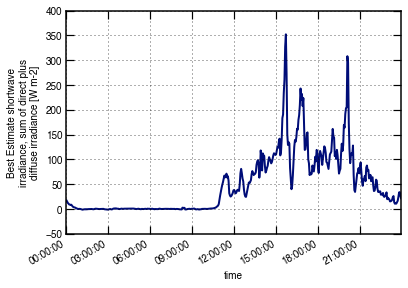

In [545]:
ds.best_estimate_shortwave_irradiance.plot()